# Inference

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
import os
os.chdir('drive/My Drive/acumen-chip-cv') # CHANGE TO THE PATH OF YOUR ROOT FOLDER

In [3]:
!pip install -r requirements.txt
!python3 setup.py install

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compiling build/bdist.linux-x86_64/egg/mrcnn/parallel_model.py to parallel_model.cpython-36.pyc
byte-compil

In [4]:
import sys
import random
import math
import re
import time
import numpy as np

%tensorflow_version 1.x
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = "."
sys.path.append(ROOT_DIR)

# Directory to save logs and trained model
MODEL_DIR = ROOT_DIR + '/logs'

# Path to Acumen trained weights
ACUMEN_WEIGHTS_PATH = ROOT_DIR + '/mask_rcnn_acumen_final.h5' # CHANGE TO THE PATH OF YOUR WEIGHTS

# Path to dataset
ACUMEN_DIR = ROOT_DIR + '/datasets'

# Import Mask RCNN
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
import acumen_config

TensorFlow 1.x selected.


Using TensorFlow backend.


## Configurations

In [5]:
config = acumen_config.AcumenConfig()

In [6]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.5

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [7]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
TEST_MODE = "inference"

In [8]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [9]:
# Load validation dataset
dataset = acumen_config.AcumenDataset()
dataset.load_acumen(ACUMEN_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 19
Classes: ['BG', 'normal', 'double_stack', 'black_spot', 'handwriting']


## Load Model

In [10]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [11]:
# Load weights
print("Loading weights ", ACUMEN_WEIGHTS_PATH)
model.load_weights(ACUMEN_WEIGHTS_PATH, by_name=True)

Loading weights  ./mask_rcnn_acumen_final.h5


## Run Detection

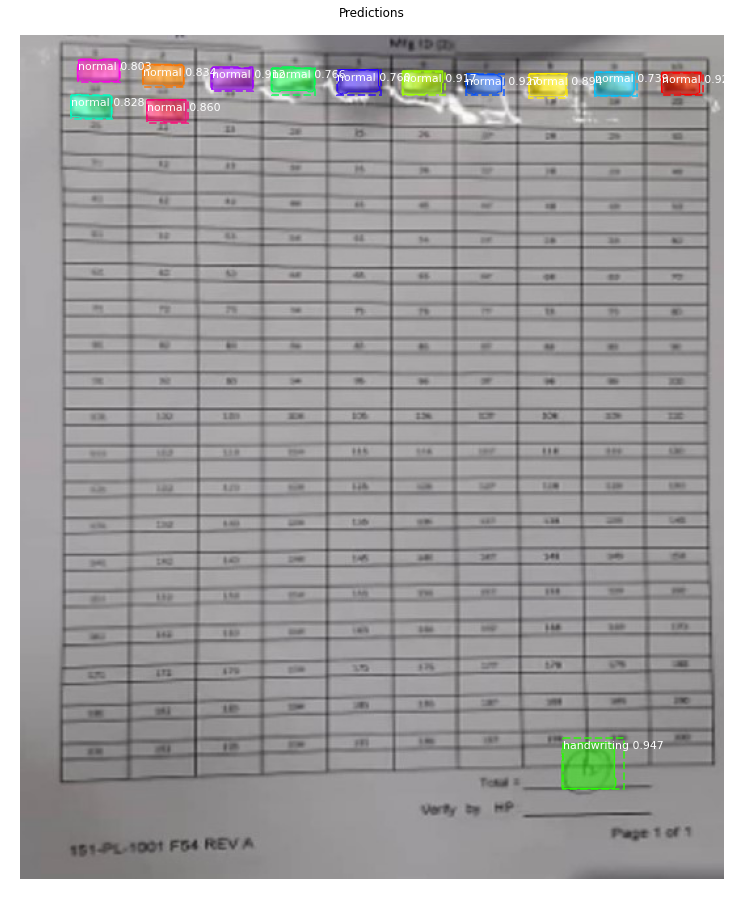

In [12]:
img_path = ACUMEN_DIR + "/test/3001.jpg" # FOR YOUR OWN TESTING

img_test = plt.imread(img_path)

# Run object detection
results = model.detect([img_test], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]

# can pass in less arguments to see less information
visualize.display_instances(img_test, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

In [13]:
# Task 1: Identify the number of chips present on each counting paper

# Count the number of normal (class_id = 1) + 2 * double_stack (class_id = 2)
list(r['class_ids']).count(1) + 2 * list(r['class_ids']).count(2)

12

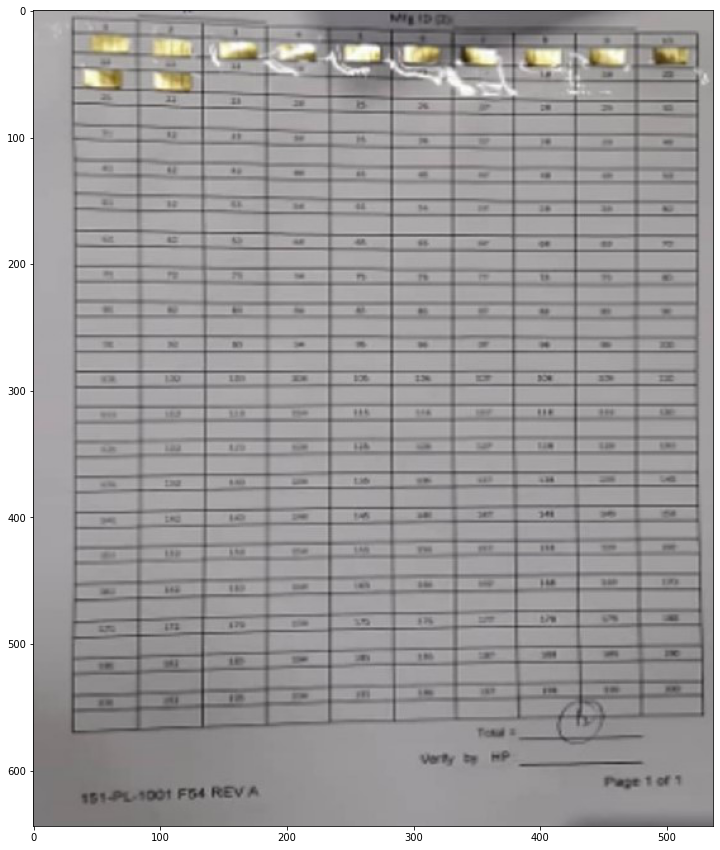

In [14]:
# Plot the original image
plt.figure(figsize=(15,15))
plt.imshow(img_test)
plt.show()

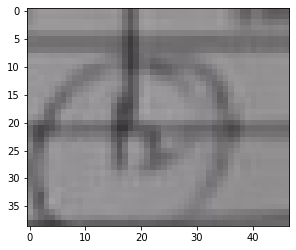

Cannot be identified


In [15]:
# Task 2: Identify the handwritten manual count present on each counting paper
import easyocr

max_so_far = -1
handwriting_region = -1
reader = easyocr.Reader(['en'])

replace_table = {
    'A': '4', 'a': '0',
    'B': '8', 'b': '6',
    'C': '6', 'c': '6',
    'D': '0', 'd': '',
    'E': '8', 'e': '',
    'F': '', 'f': '',
    'G': '6', 'g': '9',
    'H': '', 'h': '',
    'I': '1', 'i': '1',
    'J': '', 'j': '',
    'K': '', 'k': '',
    'L': '1', 'l': '1',
    'M': '', 'm': '',
    'N': '', 'n': '',
    'O': '0', 'o': '0',
    'P': '', 'p': '',
    'Q': '2', 'q': '9',
    'R': '', 'r': '',
    'S': '5', 's': '5',
    'T': '', 't': '',
    'U': '', 'u': '',
    'V': '', 'v': '',
    'W': '', 'w': '',
    'X': '', 'x': '',
    'Y': '4', 'y': '4',
    'Z': '2', 'z': '2',
    '|': '1'
}

def replace_text(text):
  # text = text.upper()
  for r in replace_table:
    text = text.replace(r, replace_table[r])
  return text

for id, score, roi in zip(r['class_ids'], r['scores'], r['rois']):
  if id == 4 and score > max_so_far:
    max_so_far = score
    handwriting_region = roi

if max_so_far == -1:
  print("No handwriting found")
else:
  y1, x1, y2, x2 = handwriting_region # coords of the handwriting region
  #print(handwriting_region)
  plt.imshow(img_test[y1: y2, x1: x2])
  plt.show()

  bounds = reader.readtext(img_test[y1: y2, x1: x2], detail=0)
  try:
    handwritten = replace_text(bounds[0])
    handwritten_count_pred = int(handwritten)
    print(handwritten_count_pred)
  except (IndexError, ValueError):
    print("Cannot be identified")

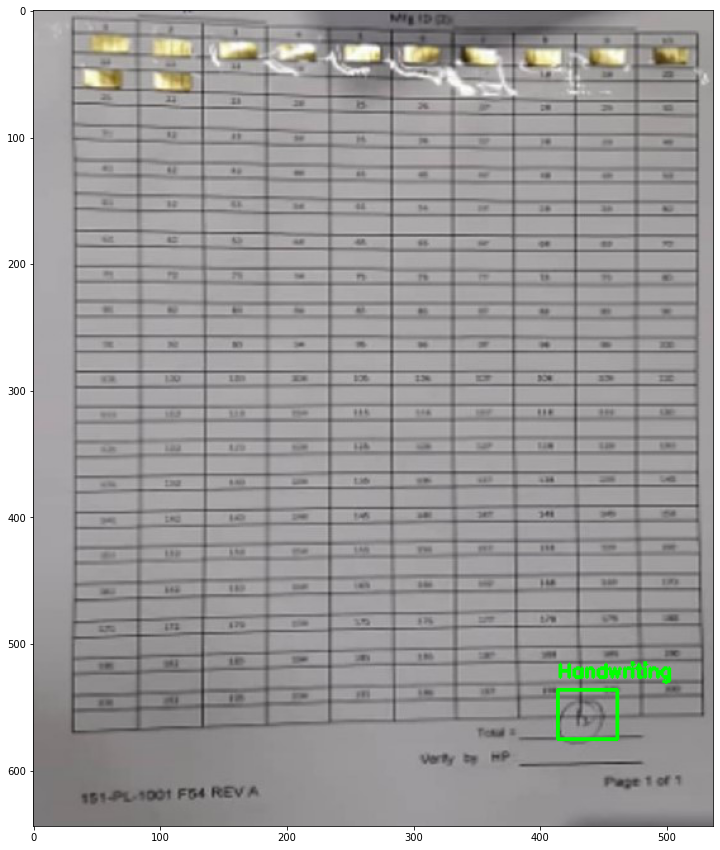

In [16]:
# Task 3: Indicate the location of anomalies with bounding boxes
# Note: Handwriting is shown here for visualization sake since anomalies are rare
import cv2 as cv2

img_test_copy = img_test.copy()

for id, roi in zip(r['class_ids'], r['rois']):
  y1, x1, y2, x2 = roi
  
  if id == 2: # double stacking
    cv2.rectangle(img_test_copy, (x1,y1), (x2,y2), (255, 0, 0), 2)
    cv2.putText(img_test_copy, 'Double stacking', (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
  elif id == 3: # black spot
    cv2.rectangle(img_test_copy, (x1,y1), (x2,y2), (0, 0, 255), 2)
    cv2.putText(img_test_copy, 'Black spot', (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
  elif id == 4: # handwriting
    cv2.rectangle(img_test_copy, (x1,y1), (x2,y2), (0, 255, 0), 2)
    cv2.putText(img_test_copy, 'Handwriting', (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

plt.figure(figsize=(15,15))
plt.imshow(img_test_copy)
plt.show()

# Submission
Instructions can be found [here](https://docs.google.com/document/d/1y4Lf0YeQOgcesvYoZR6RPlti-ACBwOsy1WEvjPMooDo/edit).

Expected submission csv format (4 cols): `img_id`, `acumen_count_pred`, `handwritten_count_pred`, `anomalies_bbox_pred`

Example: `3001, 500, 500, [('black_spot', [30, 41, 60, 20], 0.8), ('double_stack', [509, 476, 50, 31], 0.3)]`

Each detected `anomalies_bbox_pred` is a tuple of 3 elements: 
- [0] is a string that describes the anomaly: 'black_spot' or 'double_stack'
- [1] is a list of the bounding box coordinates: [top_left_x, top_left_y, width, height]
- [2] is the prediction confidence: numeric ranging from 0 to 1



In [17]:
from os import listdir
from os.path import isfile, join

test_path = ACUMEN_DIR + "/test/"
sorted_files = sorted([f for f in listdir(test_path) if isfile(join(test_path, f))])

In [18]:
import pandas as pd

df = pd.DataFrame(columns=['img_id', 'acumen_count_pred', 'handwritten_count_pred', 'anomalies_bbox_pred'])

for filename in sorted_files:
  img = plt.imread(test_path + filename)
  img_id = os.path.splitext(filename)[0]
  print("img_id: {}".format(img_id))

  # Run object detection
  results = model.detect([img], verbose=1)
  r = results[0]

  ### Task 1: Identify the number of chips present on each counting paper ###
  # Count the number of normal (class_id = 1) + 2 * double_stack (class_id = 2)
  acumen_count_pred = list(r['class_ids']).count(1) + 2 * list(r['class_ids']).count(2)

  # default count value to 250 as we realized our model could not do more 100 ROIs :<
  if acumen_count_pred >= 100:
    acumen_count_pred = 250

  print("acumen_count_pred: {}".format(acumen_count_pred))

  ### Task 2: Identify the handwritten manual count present on each counting paper ###
  # max_so_far = -1
  # handwriting_region = -1
  # for id, score, roi in zip(r['class_ids'], r['scores'], r['rois']):
  #   if id == 4 and score > max_so_far:
  #     max_so_far = score
  #     handwriting_region = roi

  # if max_so_far == -1:
  #   handwritten_count_pred = -1
  # else:
  #   y1, x1, y2, x2 = handwriting_region # coords of the handwriting region
  #   bounds = reader.readtext(img[y1: y2, x1: x2], detail=0)
    
  #   try:
  #     handwritten = replace_text(bounds[0])
  #     handwritten_count_pred = int(handwritten)
  #   except (IndexError, ValueError):
  #     # use task 1 results
  #     handwritten_count_pred = acumen_count_pred

  # Will use task 1 results instead as most handwritings are too small and OCR is not working well
  handwritten_count_pred = acumen_count_pred
  
  print("handwritten_count_pred: {}".format(handwritten_count_pred))

  ### Task 3: Indicate the location of anomalies with bounding boxes ###
  anomalies_bbox_pred = []
  for id, score, roi in zip(r['class_ids'], r['scores'], r['rois']):
    y1, x1, y2, x2 = roi
    tup = []
    if id == 2 or id == 3: # double_stack or black_spot
      tup.append(dataset.class_names[id]) # [0]: name of anomaly
      tup.append([x1, y1, x2 - x1, y2 - y1]) # [1]: [top_left_x, top_left_y, width, height]
      tup.append(round(score, 1)) # [2]: confidence score rounded off to 1 dp
      anomalies_bbox_pred.append(tuple(tup))
  
  print("anomalies_bbox_pred: {}".format(anomalies_bbox_pred), end="\n\n")

  new_row = {'img_id': img_id, 'acumen_count_pred': acumen_count_pred, 'handwritten_count_pred': handwritten_count_pred, 'anomalies_bbox_pred': anomalies_bbox_pred}
  df = df.append(new_row, ignore_index=True)

# save to root directory
df.to_csv('submissions.csv', index=False, header=True)
df.head()

img_id: 3001
acumen_count_pred: 12
handwritten_count_pred: 12
anomalies_bbox_pred: []

img_id: 3002
acumen_count_pred: 32
handwritten_count_pred: 32
anomalies_bbox_pred: []

img_id: 3003
acumen_count_pred: 6
handwritten_count_pred: 6
anomalies_bbox_pred: []

img_id: 3004
acumen_count_pred: 85
handwritten_count_pred: 85
anomalies_bbox_pred: []

img_id: 3005
acumen_count_pred: 24
handwritten_count_pred: 24
anomalies_bbox_pred: []

img_id: 3006
acumen_count_pred: 42
handwritten_count_pred: 42
anomalies_bbox_pred: []

img_id: 3007
acumen_count_pred: 6
handwritten_count_pred: 6
anomalies_bbox_pred: []

img_id: 3008
acumen_count_pred: 250
handwritten_count_pred: 250
anomalies_bbox_pred: []

img_id: 3009
acumen_count_pred: 20
handwritten_count_pred: 20
anomalies_bbox_pred: []

img_id: 3010
acumen_count_pred: 28
handwritten_count_pred: 28
anomalies_bbox_pred: []

img_id: 3011
acumen_count_pred: 15
handwritten_count_pred: 15
anomalies_bbox_pred: []

img_id: 3012
acumen_count_pred: 250
handwritt

,img_id,acumen_count_pred,handwritten_count_pred,anomalies_bbox_pred
0,3001,12,12,[]
1,3002,32,32,[]
2,3003,6,6,[]
3,3004,85,85,[]
4,3005,24,24,[]
